In [1]:
import matplotlib.pyplot as plt
import numpy as np

##################################################
# specify number of chips you are using for data
TotalChips = int(100)
# Number of Cryocycles
TotalCryo = [0,5,20,100]
##################################################

# Subrun 0 included, so this is Last Subrun Number + 1
TotalSubruns = int(30)
'''Array format:    array[Cryocycle][chip][channel]'''

chips = []
for i in range(TotalChips):
    a = 'chip' + str(i+20)
    chips.append(a)
data = []; txt = []
for c in range(len(TotalCryo)):
    data.append([]); txt.append([])
for i in range(TotalChips):
    e = 'DataRT0' + '_' + str(chips[i])
    data[0].append(e)
    f = str(chips[i]) + 'RT0Lin.dat'
    txt[0].append(f)
for i in range(TotalChips):
    g = 'DataRT5' + '_' + str(chips[i])
    data[1].append(g)
    h = str(chips[i]) + 'RT5Lin.dat'
    txt[1].append(h)
for i in range(TotalChips):
    k = 'DataRT20' + '_' + str(chips[i])
    data[2].append(k)
    l = str(chips[i]) + 'RT20Lin.dat'
    txt[2].append(l)
for i in range(TotalChips):
    k = 'DataRT100' + '_' + str(chips[i])
    data[3].append(k)
    l = str(chips[i]) + 'RT100Lin.dat'
    txt[3].append(l)

channels = 16

PA = []; Ch = []; SR = []
for c in range(len(TotalCryo)):
    PA.append([]); Ch.append([]); SR.append([])
for c in range(len(TotalCryo)):
    for i in range(TotalChips):
        PA[c].append([]); Ch[c].append([]); SR[c].append([])
for c in range(len(TotalCryo)):
    for i in range(TotalChips):
        for j in range(channels):
            PA[c][i].append([]); Ch[c][i].append([]); SR[c][i].append([])
for c in range(len(TotalCryo)):
    for i in range(TotalChips):
        for j in range(channels):
            for k in range(TotalSubruns):
                Ch[c][i][j].append(j)

for c in range(len(TotalCryo)):
    for i in range(TotalChips):
        r = np.loadtxt(str(txt[c][i]),dtype=float,delimiter=None)
        rr = r.T[0]
        p = np.loadtxt(str(txt[c][i]),dtype=float,delimiter=None)
        pulseamp = p.T[2]
        for j in range(channels):
            for k in range(TotalSubruns):
                PA[c][i][j].append(pulseamp[j+k*16])
                SR[c][i][j].append(rr[j+k*16])

print('done')

done


In [2]:
def LinearityFitter(Subrun,Pulse,chipindex,cryo):
    x = np.array(Subrun)
    T = np.array(Pulse)
    sigma = np.ones(x.size)*50

    S = np.sum(1./sigma**2.)
    Sx = np.sum(x/sigma**2.)
    Sy = np.sum(T/sigma**2.)
    Sxx = np.sum(x**2./sigma**2.)
    Sxy = np.sum(x*T/sigma**2.)

    A = np.array([[S,Sx],[Sx,Sxx]])
    b = np.array([Sy,Sxy])

    a = np.linalg.solve(A,b)
    fit = a[0]+a[1]*x

    #linear_coeff.append(a[1])
    LCoeff[cryo][chipindex].append(a[1])
    
    chisq = np.sum((T-fit)**2./sigma**2.)
    nf = x.size-a.size
    chi_red = chisq/nf
    
    #chi2.append((chi_red))
    
    return

LCoeff = []
for c in range(len(TotalCryo)):
    LCoeff.append([])
for c in range(len(TotalCryo)):
    for i in range(len(chips)):
        LCoeff[c].append([])
for c in range(len(TotalCryo)):
    for i in range(len(chips)):
        for j in range(channels):
            Subrun = SR[c][i][j]
            Pulse = PA[c][i][j]
            chipindex = i
            cryo = c
            LinearityFitter(Subrun,Pulse,chipindex,cryo)

print('done')

done


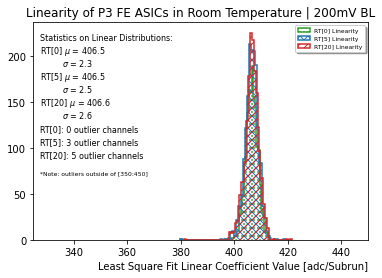


Mean of RT[0] Distribution =  406.53
Sigma of RT[0] Distribution =  2.34

Mean of RT[5] Distribution =  406.5
Sigma of RT[5] Distribution =  2.54

Mean of RT[20] Distribution =  406.58
Sigma of RT[20] Distribution =  2.63


In [3]:
from statistics import NormalDist

# # # # # # # # # # # # # # # # # # # # # # # # # # # #
# Statistics on just the "peaked" normal distribution
LC = []; bad_channel_counter = []
for c in range(len(TotalCryo)):
    LC.append([])
for c in range(len(TotalCryo)):
    count = 0.
    for i in range(len(chips)):
        for j in range(len(LCoeff[c][i])):
            if 350 < LCoeff[c][i][j] < 450:
                LC[c].append(LCoeff[c][i][j])
            else:
                count = count + 1
    bad_channel_counter.append(count)


norm_0 = NormalDist.from_samples(LC[0])
mean_0 = norm_0.mean; std_0 = norm_0.stdev
m0 = r'$\mu$' + ' = ' + str(round(mean_0,2))
s0 = r'$\sigma$' + ' = ' + str(round(std_0,2))                

norm_5 = NormalDist.from_samples(LC[1])
mean_5 = norm_5.mean; std_5 = norm_5.stdev
m5 = r'$\mu$' + ' = ' + str(round(mean_5,2))
s5 = r'$\sigma$' + ' = ' + str(round(std_5,2))

norm_20 = NormalDist.from_samples(LC[2])
mean_20 = norm_20.mean; std_20 = norm_20.stdev
m20 = r'$\mu$' + ' = ' + str(round(mean_20,2))
s20 = r'$\sigma$' + ' = ' + str(round(std_20,2))   

# # # # # # # # # # # # # # # # # # # # # # # # # # # #

fig, ax = plt.subplots()
ax.set_title('Linearity of P3 FE ASICs in Room Temperature | 200mV BL')
ax.set_xlabel('Least Square Fit Linear Coefficient Value [adc/Subrun]', loc = 'right')
ax.set_ylabel('Density', loc = 'top')

# proper binning
c = max(LC[0])-min(LC[0]); d = max(LC[1])-min(LC[1]); e = max(LC[2])-min(LC[2])
ratio = d/c; ratio_1 = e/d
bins5 = 50; bins0 = int(bins5*ratio); bins20 = int(bins5*ratio_1)


ax.hist(LC[0], bins = bins0, histtype = 'step', hatch = '...', stacked = False,
        color = 'tab:green', linewidth = 1.5, label = 'RT[0] Linearity', density = True)
ax.hist(LC[1], bins = bins5, histtype = 'step', hatch = 'xxx', stacked = False,
        color = 'tab:blue', linewidth = 1.5, label = 'RT[5] Linearity', density = True)
ax.hist(LC[2], bins = bins20, histtype = 'step', hatch = '///', stacked = False,
        color = 'tab:red', linewidth = 1.5, label = 'RT[20] Linearity', density = True)
# Labeling Mean, sigma on plot
ax.text(.02,0.92,'Statistics on Linear Distributions:',size = 8,transform = ax.transAxes)
ax.text(.02,0.86,'RT[0] ' + m0,size = 8,transform = ax.transAxes)
ax.text(.085,0.80,s0,size = 8,transform = ax.transAxes)
ax.text(.02,0.74,'RT[5] ' + m5,size = 8,transform = ax.transAxes)
ax.text(.085,0.68,s5,size = 8,transform = ax.transAxes)
ax.text(.02,0.62,'RT[20] ' + m20,size = 8,transform = ax.transAxes)
ax.text(.085,0.56,s20,size = 8,transform = ax.transAxes)

# How many channels were omitted from the nominal distribution
ax.text(.02,0.50,'RT[0]: ' + str(round(bad_channel_counter[0])) + ' outlier channels',size = 8,transform = ax.transAxes)
ax.text(.02,0.44,'RT[5]: ' + str(round(bad_channel_counter[1])) + ' outlier channels',size = 8,transform = ax.transAxes)
ax.text(.02,0.38,'RT[20]: ' + str(round(bad_channel_counter[2])) + ' outlier channels',size = 8,transform = ax.transAxes)
ax.text(.02,0.30,'*Note: outliers outside of [350:450]',size = 6,transform = ax.transAxes)

plt.xlim([325,450])

plt.legend(shadow=True, loc = 'upper right', prop={'size': 6})
path2 = '../../../../../RT Linearity.png'
plt.savefig(path2,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')
plt.show()

print('\nMean of RT[0] Distribution = ', round(mean_0,2))
print('Sigma of RT[0] Distribution = ', round(std_0,2))
print('\nMean of RT[5] Distribution = ', round(mean_5,2))
print('Sigma of RT[5] Distribution = ', round(std_5,2))
print('\nMean of RT[20] Distribution = ', round(mean_20,2))
print('Sigma of RT[20] Distribution = ', round(std_20,2))

In [5]:
mean = [mean_0, mean_5, mean_20]
std = [std_0, std_5, std_20]

for i in range(len(TotalCryo)):

    print('############## RT[' + str(TotalCryo[i]) + '] ##############')
    print('Linearity', '\nμ =', round(mean[i],2), '| σ =', round(std[i],2))
    print('3σ =', '±', round(3*std[i],2), '| 5σ =', '±', round(5*std[i],2))
    print('X-lim 3σ range = [', round(mean[i] - 3*std[i],2), ',', round(mean[i] + 3*std[i],2), ']')
    print('X-lim 5σ range = [', round(mean[i] - 5*std[i],2), ',', round(mean[i] + 5*std[i],2), ']')

    # Statistics on number of channels that were outside the 5-sigma window
    hm = 0.
    for j in range(len(LCoeff[i])):
        for k in range(len(LCoeff[i][j])):
            # 5-sigma deviation from the mean
            if LCoeff[i][j][k] > (mean[i] + 5*std[i]) or LCoeff[i][j][k] < (mean[i] - 5*std[i]):  
                hm = hm + 1
    
    print(str(hm) + '/' + str(len(LCoeff[i]*16)) + ' Channels with values outside of 5σ from mean of Nominal Linearity distribution')
    print(str(round(100*(hm/len(LCoeff[i]*16)),2)) + ' % of total channels displayed non-Linearity')

    # Statistics on number of chips that had non-linear channels
    count = []
    for j in range(len(LCoeff[i])):
        if any(e > (mean[i] + 5*std[i]) or e < (mean[i] - 5*std[i]) for e in LCoeff[i][j]):
            count.append('chip ' + str(j+20))
    print('\n' + str(len(count)) + ' Chips with at least one channel outside of 5σ from mean of Nominal Linearity distribution')
    print(str(round(100*(len(count)/TotalChips),2))+ ' % of chips with at least one non-linear channel')
    print(count,'\n')


############## RT[0] ##############
Linearity 
μ = 406.53 | σ = 2.34
3σ = ± 7.02 | 5σ = ± 11.7
X-lim 3σ range = [ 399.51 , 413.54 ]
X-lim 5σ range = [ 394.83 , 418.22 ]
1.0/1600 Channels with values outside of 5σ from mean of Nominal Linearity distribution
0.06 % of total channels displayed non-Linearity

1 Chips with at least one channel outside of 5σ from mean of Nominal Linearity distribution
1.0 % of chips with at least one non-linear channel
['chip 53'] 

############## RT[5] ##############
Linearity 
μ = 406.5 | σ = 2.54
3σ = ± 7.62 | 5σ = ± 12.7
X-lim 3σ range = [ 398.88 , 414.12 ]
X-lim 5σ range = [ 393.8 , 419.2 ]
4.0/1600 Channels with values outside of 5σ from mean of Nominal Linearity distribution
0.25 % of total channels displayed non-Linearity

4 Chips with at least one channel outside of 5σ from mean of Nominal Linearity distribution
4.0 % of chips with at least one non-linear channel
['chip 26', 'chip 41', 'chip 53', 'chip 95'] 

############## RT[20] ##############
Lin

In [4]:
'''Save data for histograms to .dat file'''

file0 = open('RT0_Linearity_Histogram_Data.dat', "w")
for i in range(len(LC[0])):             # RT[0]
    file0.write(str(LC[0][i]) + '\n')
file0.close()

file1 = open('RT5_Linearity_Histogram_Data.dat', "w")
for i in range(len(LC[1])):             # RT[5]
    file1.write(str(LC[1][i]) + '\n')
file1.close()

file2 = open('RT20_Linearity_Histogram_Data.dat', "w")
for i in range(len(LC[2])):             # RT[20]
    file2.write(str(LC[2][i]) + '\n')
file2.close()

print('done')

done


### Normalized Linearity

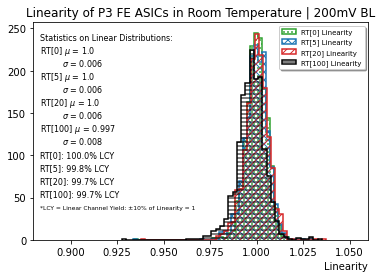


Mean of RT[0] Distribution =  1.0
Sigma of RT[0] Distribution =  0.01

Mean of RT[5] Distribution =  1.0
Sigma of RT[5] Distribution =  0.01

Mean of RT[20] Distribution =  1.0
Sigma of RT[20] Distribution =  0.01

Mean of RT[100] Distribution =  1.0
Sigma of RT[100] Distribution =  0.01


In [3]:
'''
Here, we define the mean of the RT[0] distribution as being linearity 1, so every other
distribution is normalized to RT[0], including CT distributions
'''

from statistics import NormalDist

'''
Mean of RT[0] Distribution: 406.53
'''
Normalized_Mean = 406.53
plus_10 = 406.53 + 406.53*.1
minus_10 = 406.53 - 406.53*.1

# We will take outlier channel % as a ratio of bad channels to 'eligible' channels (excluding disconnections)
'''
Total Number of Channels, excluding disconnections for RT:
RT[0]:  1600
RT[5]:  1600
RT[20]:  1599
RT[100]:  1543
'''
CC0 = 1600
CC5 = 1600
CC20 = 1599
CC100 = 1543

# # # # # # # # # # # # # # # # # # # # # # # # # # # #
# Statistics on just the "peaked" normal distribution

# Assume that all disconnections have linearity outside +/-10%
# The length of LC (linearity values only appended inside +/-10%) divided by
# the number of non-disconnections (above) shows the channel 'yield' - aka the
# percentage of good channels

LC = []; counter = []
for c in range(len(TotalCryo)):
    LC.append([]); counter.append([])
for c in range(len(TotalCryo)):
    count = 0.
    for i in range(len(chips)):
        for j in range(len(LCoeff[c][i])):
            if minus_10 < LCoeff[c][i][j] < plus_10:   # Define range +/-10%
                LC[c].append(LCoeff[c][i][j])
    
    count = len(LC[c])
    counter[c].append(count)


# Normalization
for c in range(len(TotalCryo)):
    for i in range(len(LC[c])):
        LC[c][i] = LC[c][i]/Normalized_Mean

norm_0 = NormalDist.from_samples(LC[0])
mean_0 = norm_0.mean; std_0 = norm_0.stdev
m0 = r'$\mu$' + ' = ' + str(round(mean_0,3))
s0 = r'$\sigma$' + ' = ' + str(round(std_0,3))                

norm_5 = NormalDist.from_samples(LC[1])
mean_5 = norm_5.mean; std_5 = norm_5.stdev
m5 = r'$\mu$' + ' = ' + str(round(mean_5,3))
s5 = r'$\sigma$' + ' = ' + str(round(std_5,3))

norm_20 = NormalDist.from_samples(LC[2])
mean_20 = norm_20.mean; std_20 = norm_20.stdev
m20 = r'$\mu$' + ' = ' + str(round(mean_20,3))
s20 = r'$\sigma$' + ' = ' + str(round(std_20,3))

norm_100 = NormalDist.from_samples(LC[3])
mean_100 = norm_100.mean; std_100 = norm_100.stdev
m100 = r'$\mu$' + ' = ' + str(round(mean_100,3))
s100 = r'$\sigma$' + ' = ' + str(round(std_100,3))   

# # # # # # # # # # # # # # # # # # # # # # # # # # # #

fig, ax = plt.subplots()
ax.set_title('Linearity of P3 FE ASICs in Room Temperature | 200mV BL')
ax.set_xlabel('Linearity', loc = 'right')

# proper binning
c = max(LC[0])-min(LC[0]); d = max(LC[1])-min(LC[1]); e = max(LC[2])-min(LC[2]); f = max(LC[3])-min(LC[3])
ratio = d/c; ratio_1 = e/c; ratio_2 = f/c 
bins0 = 40; bins5 = int(bins0*ratio); bins20 = int(bins0*ratio_1); bins100 = int(bins0*ratio_2)

ax.hist(LC[0], bins = bins0, histtype = 'step', hatch = '...', stacked = False,
        color = 'tab:green', linewidth = 1.5, label = 'RT[0] Linearity')
ax.hist(LC[1], bins = bins5, histtype = 'step', hatch = 'xxx', stacked = False,
        color = 'tab:blue', linewidth = 1.5, label = 'RT[5] Linearity')
ax.hist(LC[2], bins = bins20, histtype = 'step', hatch = '///', stacked = False,
        color = 'tab:red', linewidth = 1.5, label = 'RT[20] Linearity')
ax.hist(LC[3], bins = bins20, histtype = 'step', hatch = '---', stacked = False,
        color = 'black', linewidth = 1.5, label = 'RT[100] Linearity')

# Labeling Mean, sigma on plot
ax.text(.02,0.92,'Statistics on Linear Distributions:',size = 8,transform = ax.transAxes)
ax.text(.02,0.86,'RT[0] ' + m0,size = 8,transform = ax.transAxes)
ax.text(.085,0.80,s0,size = 8,transform = ax.transAxes)
ax.text(.02,0.74,'RT[5] ' + m5,size = 8,transform = ax.transAxes)
ax.text(.085,0.68,s5,size = 8,transform = ax.transAxes)
ax.text(.02,0.62,'RT[20] ' + m20,size = 8,transform = ax.transAxes)
ax.text(.085,0.56,s20,size = 8,transform = ax.transAxes)
ax.text(.02,0.50,'RT[100] ' + m100,size = 8,transform = ax.transAxes)
ax.text(.085,0.44,s100,size = 8,transform = ax.transAxes)

# How many channels were omitted from the nominal distribution
ax.text(.02,0.38,'RT[0]: ' + str(round((counter[0][0]/CC0)*100,1)) + '% LCY',size = 8,transform = ax.transAxes)
ax.text(.02,0.32,'RT[5]: ' + str(round((counter[1][0]/CC5)*100,1)) + '% LCY',size = 8,transform = ax.transAxes)
ax.text(.02,0.26,'RT[20]: ' + str(round((counter[2][0]/CC20)*100,1)) + '% LCY',size = 8,transform = ax.transAxes)
ax.text(.02,0.20,'RT[100]: ' + str(round((counter[3][0]/CC100)*100,1)) + '% LCY',size = 8,transform = ax.transAxes)
ax.text(.02,0.14,'*LCY = Linear Channel Yield: ' + u"\u00B1" + '10% of Linearity = 1', size = 6,transform = ax.transAxes)

plt.xlim([0.88,1.06])
# Zoomed out version:
#plt.xlim([0,1.4])

plt.legend(shadow=True, loc = 'upper right', prop={'size': 7})
path2 = '../../../../../RT Normalized Linearity.png'
plt.savefig(path2,dpi=300, bbox_inches='tight', pad_inches=.3,facecolor = 'w')
plt.show()

print('\nMean of RT[0] Distribution = ', round(mean_0,2))
print('Sigma of RT[0] Distribution = ', round(std_0,2))
print('\nMean of RT[5] Distribution = ', round(mean_5,2))
print('Sigma of RT[5] Distribution = ', round(std_5,2))
print('\nMean of RT[20] Distribution = ', round(mean_20,2))
print('Sigma of RT[20] Distribution = ', round(std_20,2))
print('\nMean of RT[100] Distribution = ', round(mean_100,2))
print('Sigma of RT[100] Distribution = ', round(std_100,2))


In [11]:
print(counter[3][0]/CC100)

0.9967595593000648


In [10]:
print(counter[2][0]/CC20)

0.9974984365228268
